In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.3/612.3 kB 13.1 MB/s eta 0:00:00


In [3]:
# Import libraries
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import tensorflow as tf
import tensorflow_addons as tfa

from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, GlobalMaxPooling2D, AveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB0, ResNet101
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [4]:

# Define dataset2 paths
data_dir = "/content/drive/MyDrive/SHSU-Projects/Final_files/Knee_Dataset_2_Augmented/train_augmented"


# Define batch size
batch_size = 20
IMAGE_SIZE = (240, 240)
classes = ['0Normal', '1Doubtful', '2Mild', '3Moderate', '4Severe']


train_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='categorical',
    class_names=classes,  # Specify your class names
    shuffle=True,
    batch_size=batch_size,
    image_size=IMAGE_SIZE,
    validation_split=0.2,  # Adjust the validation split as needed
    subset='training',
    seed=1337
)



val_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='categorical',
    class_names=classes,
    shuffle=True,
    batch_size=batch_size,
    image_size=IMAGE_SIZE,
    validation_split=0.2,
    subset='validation',
    seed=1337
)



class_index_to_label = {i: label for i, label in enumerate(train_dataset.class_names)}
print('Class index number mapping to class folder names: ',class_index_to_label)


def preprocess_image(image, label):
    image = tfa.image.equalize(image)
    return image, label


train_dataset = train_dataset.map(preprocess_image).shuffle(buffer_size=200)
val_dataset = val_dataset.map(preprocess_image)


train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)


Found 6725 files belonging to 5 classes.
Using 5380 files for training.
Found 6725 files belonging to 5 classes.
Using 1345 files for validation.
Class index number mapping to class folder names:  {0: '0Normal', 1: '1Doubtful', 2: '2Mild', 3: '3Moderate', 4: '4Severe'}


In [5]:

# base_model = tf.keras.applications.efficientnet.EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
#base_model = tf.keras.applications.resnet.ResNet101(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
base_model = tf.keras.applications.convnext.ConvNeXtBase(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

x = base_model.output
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(612, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(210, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.Dropout(0.5)(x)
predictions = tf.keras.layers.Dense(5, activation='softmax')(x)

for layer in base_model.layers:
    layer.trainable = True

model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

350926856/350926856 [==============================] - 1s 0us/step


List of learning rate:  [6.25e-06, 1.25e-05, 2.5e-05, 5e-05, 0.0001, 9.964234631709187e-05, 9.857450191464337e-05, 9.681174353198687e-05, 9.437928945022771e-05, 9.131193871579975e-05, 8.765357330018056e-05, 8.345653031794292e-05, 7.878085328428369e-05, 7.369343312364993e-05, 6.826705121831976e-05, 6.257933818722543e-05, 5.6711663290882776e-05, 5.074797035076319e-05, 4.477357683661734e-05, 3.887395330218429e-05, 3.3133500630858515e-05, 2.7634342584218365e-05, 2.245515092739488e-05, 1.7670019939210024e-05, 1.3347406408508695e-05]


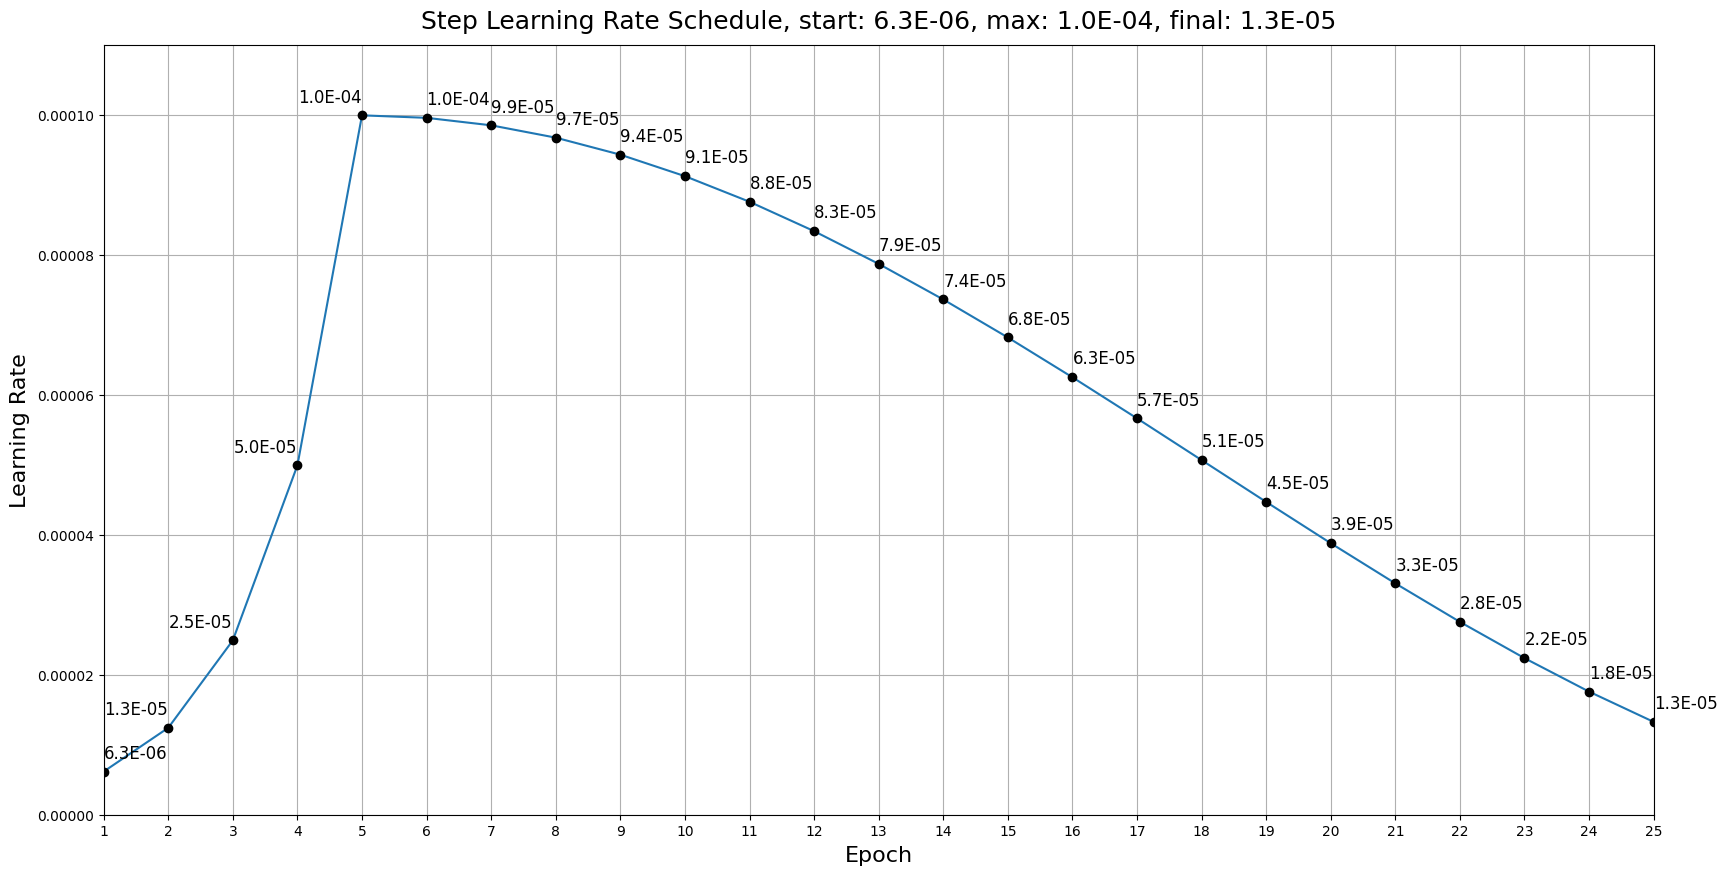

In [6]:
# Import libraries
import math
import sklearn
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

N_EPOCHS = 25
warm_up_ep  = 4
num_cycles  = 0.4
lr_max = 1e-4

def learning_rate_fn(current_step, num_warmup_steps, lr_max, num_cycles=0.50, num_training_steps=N_EPOCHS):
    if current_step < num_warmup_steps:
        # exponiancial warmup
        return lr_max * 2 ** -(num_warmup_steps - current_step)
    else:
        progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))
        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress))) * lr_max


def plot_lr_schedule(lr_schedule, epochs):
    fig = plt.figure(figsize=(20, 10))
    plt.plot([None] + lr_schedule + [None])
    x = np.arange(1, epochs + 1)
    x_axis_labels = [i if epochs <= 40 or i % 5 == 0 or i == 1 else None for i in range(1, epochs + 1)]
    plt.xlim([1, epochs])
    plt.xticks(x, x_axis_labels) # set tick step to 1 and let x axis start at 1

    plt.ylim([0, max(lr_schedule) * 1.1])

    schedule_info = f'start: {lr_schedule[0]:.1E}, max: {max(lr_schedule):.1E}, final: {lr_schedule[-1]:.1E}'
    plt.title(f'Step Learning Rate Schedule, {schedule_info}', size=18, pad=12)

    for x, val in enumerate(lr_schedule):
        if epochs <= 40 or x % 5 == 0 or x is epochs - 1:
            if x < len(lr_schedule) - 1:
                if lr_schedule[x - 1] < val:
                    ha = 'right'
                else:
                    ha = 'left'
            elif x == 0:
                ha = 'right'
            else:
                ha = 'left'
            plt.plot(x + 1, val, 'o', color='black');
            offset_y = (max(lr_schedule) - min(lr_schedule)) * 0.02
            plt.annotate(f'{val:.1E}', xy=(x + 1, val + offset_y), size=12, ha=ha)

    plt.xlabel('Epoch', size=16, labelpad=5)
    plt.ylabel('Learning Rate', size=16, labelpad=5)
    plt.grid()
    plt.show()




LR_SCHEDULE = [learning_rate_fn(step, num_warmup_steps=warm_up_ep, lr_max=lr_max, num_cycles=num_cycles, num_training_steps=N_EPOCHS) for step in range(N_EPOCHS)]
print('List of learning rate: ', LR_SCHEDULE)

plot_lr_schedule(LR_SCHEDULE, epochs=N_EPOCHS)
#lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda step: LR_SCHEDULE[step], verbose=0)



In [7]:
LR_SCHEDULE

[6.25e-06,
 1.25e-05,
 2.5e-05,
 5e-05,
 0.0001,
 9.964234631709187e-05,
 9.857450191464337e-05,
 9.681174353198687e-05,
 9.437928945022771e-05,
 9.131193871579975e-05,
 8.765357330018056e-05,
 8.345653031794292e-05,
 7.878085328428369e-05,
 7.369343312364993e-05,
 6.826705121831976e-05,
 6.257933818722543e-05,
 5.6711663290882776e-05,
 5.074797035076319e-05,
 4.477357683661734e-05,
 3.887395330218429e-05,
 3.3133500630858515e-05,
 2.7634342584218365e-05,
 2.245515092739488e-05,
 1.7670019939210024e-05,
 1.3347406408508695e-05]

In [8]:
#lr_list = [ 0.00001, 0.00006, 0.00003, 0.00002, 0.00002, 0.00001, 0.00001, 0.00001, 0.00001, 0.00001, 0.00001 ]


my_callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath='/content/drive/MyDrive/SHSU-Projects/Final_files/Dataset_2_after_augmentation_convex_UI.h5', save_best_only=True),
    #tf.keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=1),
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=7, restore_best_weights=True),  # Stop training if no improvement after 3 epochs
    #tf.keras.callbacks.LearningRateScheduler(lambda step: lr_list[step], verbose=0),
    tf.keras.callbacks.LearningRateScheduler(lambda step: LR_SCHEDULE[step], verbose=0)
    #tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=3, min_lr=1e-5, verbose=1)
]


In [9]:



model.compile(
    optimizer= tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=['accuracy']
)


history = model.fit(
    train_dataset,
    epochs=N_EPOCHS,
    validation_data=val_dataset,
    callbacks=[my_callbacks],
)



Epoch 1/25
269/269 [==============================] - ETA: 0s - loss: 22.4787 - accuracy: 0.2638

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


269/269 [==============================] - 366s 563ms/step - loss: 22.4787 - accuracy: 0.2638 - val_loss: 22.1042 - val_accuracy: 0.4669 - lr: 6.2500e-06
Epoch 2/25
269/269 [==============================] - 109s 392ms/step - loss: 21.5698 - accuracy: 0.4716 - val_loss: 20.8440 - val_accuracy: 0.6379 - lr: 1.2500e-05
Epoch 3/25
269/269 [==============================] - 108s 389ms/step - loss: 20.0287 - accuracy: 0.6749 - val_loss: 18.9535 - val_accuracy: 0.8112 - lr: 2.5000e-05
Epoch 4/25
269/269 [==============================] - 112s 396ms/step - loss: 17.6874 - accuracy: 0.7848 - val_loss: 16.3102 - val_accuracy: 0.8045 - lr: 5.0000e-05
Epoch 5/25
269/269 [==============================] - 109s 389ms/step - loss: 13.9221 - accuracy: 0.8418 - val_loss: 12.2121 - val_accuracy: 0.7524 - lr: 1.0000e-04
Epoch 6/25
269/269 [==============================] - 111s 387ms/step - loss: 9.8750 - accuracy: 0.9216 - val_loss: 8.5479 - val_accuracy: 0.8327 - lr: 9.9642e-05
Epoch 7/25
269/269 [===

KeyboardInterrupt: ignored

In [10]:
# Create a dictionary to store layer counts
layer_counts = {}

# Iterate through the model's layers
for layer in model.layers:
    layer_type = type(layer).__name__
    if layer_type in layer_counts:
        layer_counts[layer_type] += 1
    else:
        layer_counts[layer_type] = 1

# Print the total layer counts for each layer type
for layer_type, count in layer_counts.items():
    print(f"Layer type '{layer_type}' is applied {count} times.")


Layer type 'InputLayer' is applied 1 times.
Layer type 'Normalization' is applied 1 times.
Layer type 'Sequential' is applied 4 times.
Layer type 'Conv2D' is applied 36 times.
Layer type 'LayerNormalization' is applied 37 times.
Layer type 'Dense' is applied 76 times.
Layer type 'Activation' is applied 72 times.
Layer type 'LayerScale' is applied 36 times.
Layer type 'TFOpLambda' is applied 36 times.
Layer type 'BatchNormalization' is applied 1 times.
Layer type 'GlobalAveragePooling2D' is applied 1 times.
Layer type 'Dropout' is applied 3 times.


In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 240, 240, 3)]        0         []                            
                                                                                                  
 convnext_base_prestem_norm  (None, 240, 240, 3)          0         ['input_1[0][0]']             
 alization (Normalization)                                                                        
                                                                                                  
 convnext_base_stem (Sequen  (None, 60, 60, 128)          6528      ['convnext_base_prestem_normal
 tial)                                                              ization[0][0]']               
                                                                                              

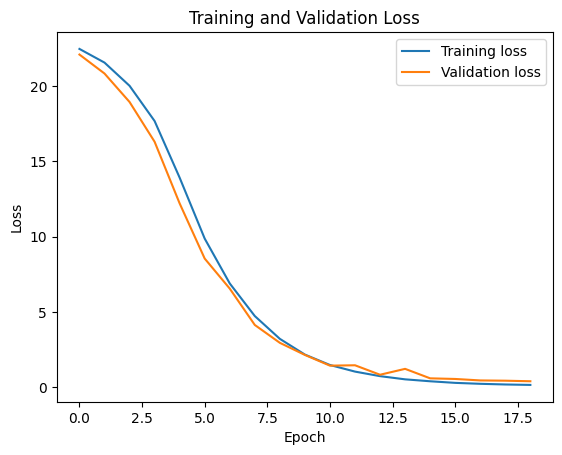

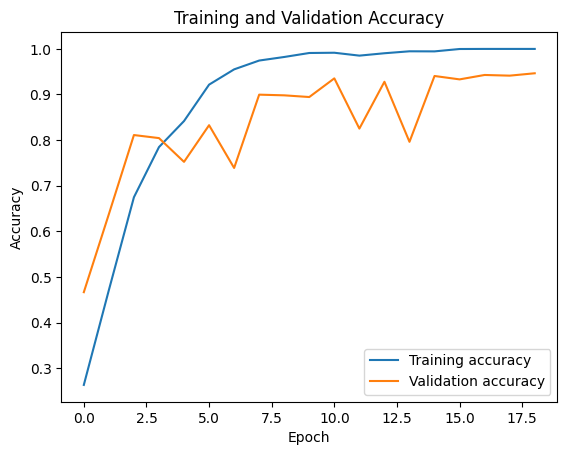

In [12]:
import matplotlib.pyplot as plt

# Plot the training and validation loss curves
plt.plot(model.history.history['loss'], label='Training loss')
plt.plot(model.history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy curves
plt.plot(model.history.history['accuracy'], label='Training accuracy')
plt.plot(model.history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


1/1 [==============================] - 0s 58ms/step
Confusion Matrix:


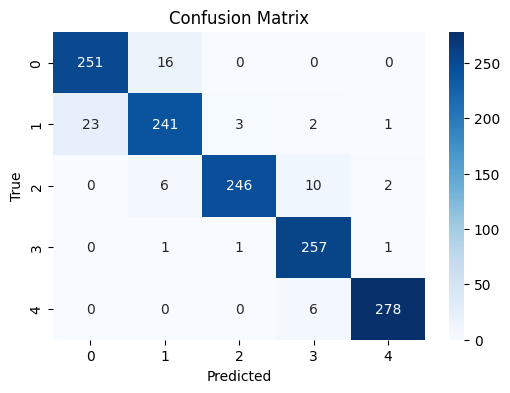


Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.94      0.93       267
           1       0.91      0.89      0.90       270
           2       0.98      0.93      0.96       264
           3       0.93      0.99      0.96       260
           4       0.99      0.98      0.98       284

    accuracy                           0.95      1345
   macro avg       0.95      0.95      0.95      1345
weighted avg       0.95      0.95      0.95      1345



In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import numpy as np


val_results = model.evaluate(val_dataset)

y_true = []
y_pred = []

for x_val, y_val in val_dataset:
    predictions = model.predict(x_val)
    y_true.extend(np.argmax(y_val, axis=1))
    y_pred.extend(np.argmax(predictions, axis=1))

cm = confusion_matrix(y_true, y_pred)

print("Confusion Matrix:")
#print(cm)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print("\nClassification Report:")
print(classification_report(y_true, y_pred))


## Save | Load trained model

In [14]:
model.save_weights('/content/drive/MyDrive/SHSU-Projects/Final_files/Dataset_2_after_augmented_convxNxtBase_model_weights.weight')
# model.load_weights('your_trained_model.weight')


## Save tflite model

In [15]:
model.save('model_saved_dir')     # saving model temp in  directory format
converter = tf.lite.TFLiteConverter.from_saved_model('model_saved_dir')

converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()


tflite_model_path = '/content/drive/MyDrive/SHSU-Projects/Final_files/Dataset_2_after_augmented_convxNxtBase_model_tflite.tflite'
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)


print('TFLite model saved at:', tflite_model_path)

TFLite model saved at: /content/drive/MyDrive/SHSU-Projects/Final_files/Dataset_2_after_augmented_convxNxtBase_model_tflite.tflite


## Do the inference using tflite (Testing)

In [23]:
import tensorflow as tf
import cv2

# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Assuming your input image is in 'input_image.jpg'
#input_image = '/content/drive/MyDrive/SHSU-Projects/Final_files/KneeOA_Dataset_2_Original/test/0Normal/NormalG0 (433).png'
# input_image = '/content/drive/MyDrive/SHSU-Projects/Final_files/KneeOA_Dataset_2_Original/test/1Doubtful/DoubtfulG1 (433).png'
input_image = '/content/drive/MyDrive/SHSU-Projects/Final_files/KneeOA_Dataset_2_Original/test/2Mild/MildG2 (172).png'
# input_image = '/content/drive/MyDrive/SHSU-Projects/Final_files/KneeOA_Dataset_2_Original/test/3Moderate/ModerateG3 (162).png'
# input_image = '/content/drive/MyDrive/SHSU-Projects/Final_files/KneeOA_Dataset_2_Original/test/4Severe/SevereG4 (192).png'

rgb_image = cv2.cvtColor(cv2.imread(input_image), cv2.COLOR_BGR2RGB)
rgb_image = tfa.image.equalize(rgb_image)

input_data = tf.image.resize(rgb_image, IMAGE_SIZE)
input_data = tf.cast(input_data, tf.float32)
input_data = tf.expand_dims(input_data, axis=0)

input_data = tf.keras.applications.resnet50.preprocess_input(input_data)

interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()

output_data = interpreter.get_tensor(output_details[0]['index'])

predicted_class = tf.argmax(output_data[0]).numpy()

print(f"Predicted class: {predicted_class}")


Predicted class: 2


## GUI (Standalone code)

In [17]:
!pip3 install gradio==3.43.2 -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.1/20.1 MB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.9/92.9 kB 15.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.2/298.2 kB 40.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.7/311.7 kB 41.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 11.6

In [19]:
pip install typing_extensions==4.7.1 --upgrade

  Attempting uninstall: typing_extensions
    Found existing installation: typing_extensions 4.8.0
    Uninstalling typing_extensions-4.8.0:
      Successfully uninstalled typing_extensions-4.8.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires kaleido, which is not installed.
fastapi 0.104.1 requires typing-extensions>=4.8.0, but you have typing-extensions 4.7.1 which is incompatible.
tensorflow-probability 0.22.0 requires typing-extensions<4.6.0, but you have typing-extensions 4.7.1 which is incompatible.


In [20]:
import gradio as gr
import tensorflow as tf
import cv2

# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path='/content/drive/MyDrive/SHSU-Projects/Final_files/Dataset_2_after_augmented_convxNxtBase_model_tflite.tflite')
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

def classify_image(image):

    #image = cv2.cvtColor(cv2.imread(image), cv2.COLOR_BGR2RGB)
    image = tfa.image.equalize(image)
    input_data = image.resize((256, 256))
    input_data = tf.cast(input_data, tf.float32)
    input_data = tf.expand_dims(input_data, axis=0)


    input_data = tf.keras.applications.resnet50.preprocess_input(input_data)

    interpreter.set_tensor(input_details[0]['index'], input_data)

    interpreter.invoke()

    output_data = interpreter.get_tensor(output_details[0]['index'])

    predicted_class = tf.argmax(output_data[0]).numpy()

    print(f"Predicted class: {predicted_class}")

    class_list = ['Healthy', 'Doubtful', 'Minimal', 'Moderate', 'Severe']
    return class_list[predicted_class]



gr.Interface(fn=classify_image,
             inputs=gr.Image(type="pil"),
             outputs=gr.Label(num_top_classes=5)).launch(share=True)


ImportError: ignored